In [1]:
from datasets import load_dataset
import numpy as np
import os
import glob
from PIL import Image
import csv

import torch
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from dotenv import load_dotenv
from label_studio_sdk.client import LabelStudio

/Users/sarathmenon/llm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### From human-label exported file with COCO stuyle image segmentation info for rectangles and polygons

In [12]:
import torchvision
from torchvision import transforms

# Define the path to the COCO dataset
data_dir = '../datasets/label_studio_gen/coco_dataset/images'
annFile = '../datasets/label_studio_gen/coco_dataset/result.json'

# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the COCO dataset
coco_dataset = torchvision.datasets.CocoDetection(root=data_dir, annFile=annFile, transform=transform)
class_labels = [cat['name'] for cat in coco_dataset.coco.cats.values()]
print(class_labels)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
['bag', 'ball', 'barrel', 'bird', 'book', 'box', 'bush', 'cabinet', 'can', 'cannon', 'cap', 'car', 'chair', 'coin', 'computer', 'crate', 'door', 'fire_hydrant', 'flag', 'globe', 'hat', 'instrument', 'lamp', 'mirror', 'moon', 'oven', 'painting', 'pillar', 'pillow', 'plant', 'refrigerator', 'ring', 'skull', 'sphere', 'stick', 'stone', 'sword', 'table', 'telescope', 'television', 'trash can', 'treasure', 'tree', 'vase', 'watertank', 'window']


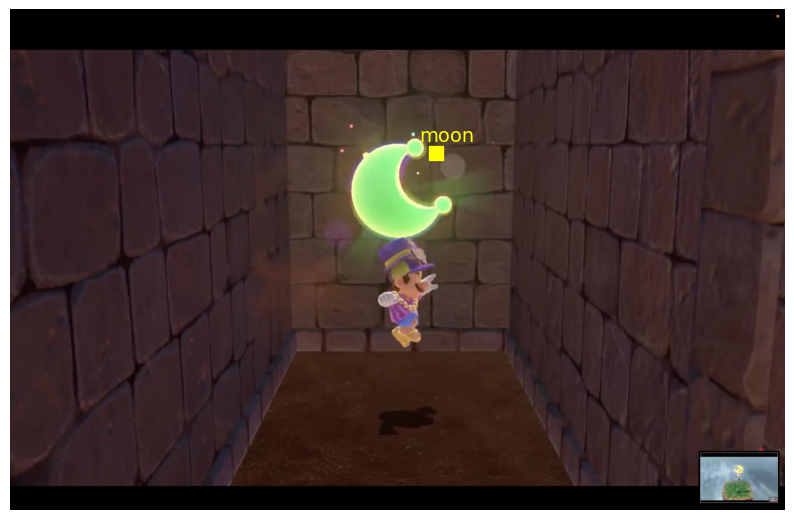

In [194]:
from matplotlib.path import Path
import matplotlib.patches as patches

def plot_click_point(image, click_point, annotations):
    
    image = image.permute(1, 2, 0)  # Transpose the image tensor
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        # plot class label
        class_label = class_labels[annotation['category_id']]

        class_label_x = annotation['segmentation'][0][0]
        class_label_y = annotation['segmentation'][0][1] 
        plt.text(class_label_x, class_label_y, class_label, fontsize=14, color='yellow')

    colors = ['yellow', 'red']
    shapes = ['s', 'o']
    for i, point in enumerate(click_point):
        plt.plot(point['x'], point['y'], shapes[i],  color=colors[i], markersize=10)

    plt.axis('off')
    plt.grid(False)
    plt.show()

# Example usage:
index = 2
click_point = {'x': 950, 'y': 320, 'valid': True}
img, annotations = coco_dataset[index]
plot_click_point(img, [click_point], annotations)

## Corrector model

Distance:  {'x': '0.05', 'y': '-0.1', 'reason': "The label is slightly to the left and above the moon's center."}
{'x': 1229.25, 'y': 579.2}


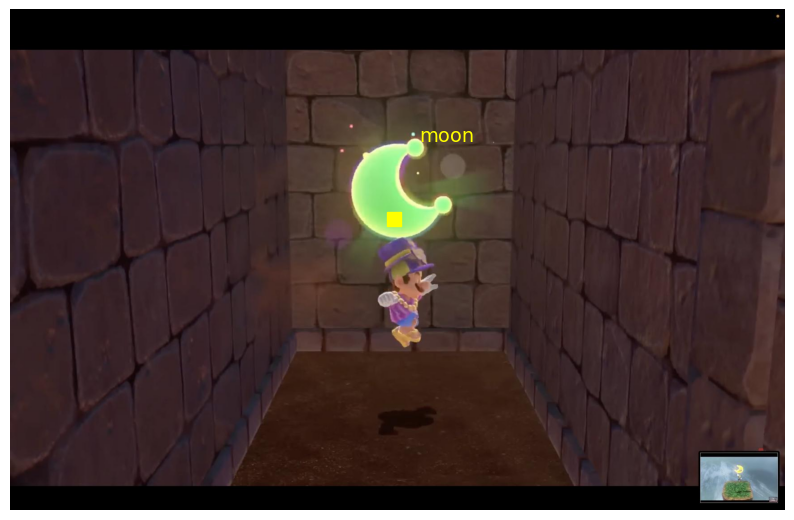

In [196]:
from openai import OpenAI
import os
import io
import torchvision.transforms as transforms
import base64

def image_to_base64(img):
    to_pil = transforms.ToPILImage()
    img_pil = to_pil(img.mul(255).byte())
    buffered = io.BytesIO()
    img_pil.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

MODEL = "gpt-4o"
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

system_prompt = "You are a helpful assistant and an identifying objects in videogame images."

user_prompt = """Consider the object labelled as moon in the image. How should the label be shifted such that it falls in the center of the moon ? Give distance to be shifted, where the horizontal unit of distance is the width of the image and the vertical unit of distance is the height of the image. Also give a reason why you chose the distance in 20 words. Give the output in json format with the following keys: {'x': '<distance>', 'y': '<distance>', 'reason': '<reason>'}
"""

base64_image = image_to_base64(img)

response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": [
            {"type": "text", "text": user_prompt},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ],
    stream=False,
    response_format={"type": "json_object"},
    temperature=0.0,
)


shifted_click_points = get_shifted_point(img, annotations)
print(shifted_click_point)
plot_click_point(img, shifted_click_points, annotations)

Distance:  {'x': '0.55', 'y': '0.35', 'reason': 'The moon is located at approximately 55% width and 35% height of the image.'}


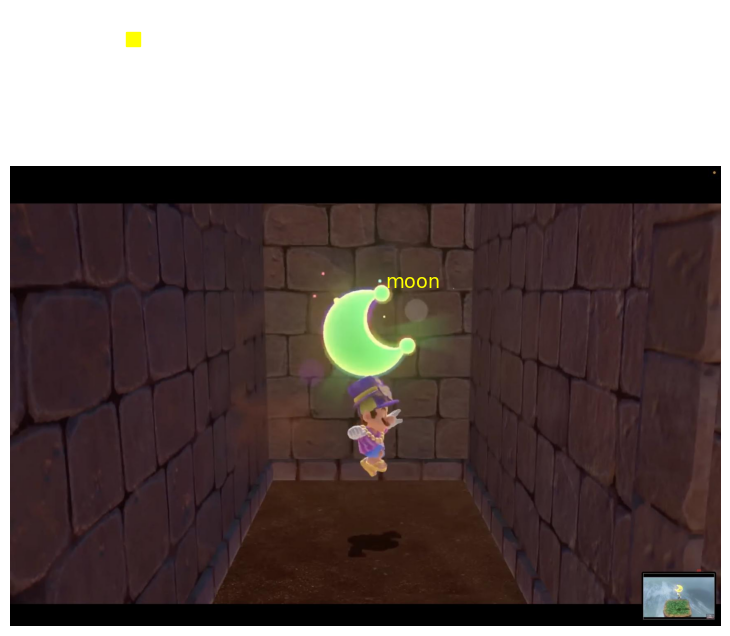

In [191]:
def get_shifted_point(img, annotations):
    img_width = img.shape[1]
    img_height = img.shape[2]

    distances = json.loads(response.choices[0].message.content)
    x_shift = float(distances['x']) * img_width
    y_shift = float(distances['y']) * img_height
    print("Distance: ", distances)

    # print(f"img_width: {img_width}, img_height: {img_height}")
    # print(f"x_shift: {x_shift}, y_shift: {y_shift}")

    click_points = []
    
    for annotation in annotations:
        # plot class label
        class_label_x = annotation['segmentation'][0][0]
        class_label_y = annotation['segmentation'][0][1] 
        click_points.append({'x': class_label_x - x_shift, 'y': class_label_y - y_shift})
            
    return click_points

shifted_click_points = get_shifted_point(img, annotations)
plot_click_point(img, shifted_click_points, annotations)